In [1]:
import pandas as pd
import numpy as np

column_names_full = [
    "track_id", "race_date", "race_number", "program_number",
    "trakus_index", "latitude", "longitude", "distance_id",
    "course_type", "track_condition", "run_up_distance", 
    "race_type", "post_time", "weight_carried", "jockey", 
    "odds", "position_at_finish"
]

column_names_desired = [
    "race_date", "race_number", "program_number", "trakus_index", "latitude", "longitude", "distance_id", "course_type", "track_condition",
    "race_type", "weight_carried", "jockey", 
    "odds", "position_at_finish"
]

# Load the dataset
df = pd.read_csv("nyra_2019_complete.csv", header=None, usecols=[1,2,3,4,5,6,7,8,9,11,14,15,16,17], names=column_names_desired)[column_names_desired]

# Inspect the data
df.info()
df.head()

C:\Users\ahmet\AppData\Local\Temp\ipykernel_5264\3901139008.py:19: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("nyra_2019_complete.csv", header=None, usecols=[1,2,3,4,5,6,7,8,9,11,14,15,16,17], names=column_names_desired)[column_names_desired]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   race_date           object 
 1   race_number         int64  
 2   program_number      object 
 3   trakus_index        int64  
 4   latitude            float64
 5   longitude           float64
 6   distance_id         int64  
 7   course_type         object 
 8   track_condition     object 
 9   race_type           object 
 10  weight_carried      int64  
 11  jockey              object 
 12  odds                int64  
 13  position_at_finish  int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 558.5+ MB


,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,race_type,weight_carried,jockey,odds,position_at_finish
0,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
1,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
2,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
3,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8
4,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,CLM,120,Andre Shivnarine Worrie,2090,8


In [2]:
# Preprocessing
# ---
# Dropping nulls
df = df.dropna(axis=0)

# Dropping duplicates
df.drop_duplicates(inplace=True, subset=['odds'])

# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['distance_id', 'weight_carried', 'odds']] = scaler.fit_transform(df[['distance_id', 'weight_carried', 'odds']])

# Scaled columns
df.head()[['distance_id', 'weight_carried', 'odds']]

,distance_id,weight_carried,odds
0,0.034483,0.200000,0.109424
297,0.034483,0.200000,0.017539
572,0.034483,0.222222,0.132199
845,0.034483,0.266667,0.068063
1125,0.000000,0.244444,0.063351


In [7]:
# Feature Engineering
df = df.sort_values(by='race_date')

# Mean finishing position of each jockey
df['jockey_score'] = (
    df.groupby('jockey')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)
)

global_mean_jockey = df['jockey_score'].mean()
df['jockey_score'] = df['jockey_score'].fillna(global_mean_jockey)

# Calculate horse_track_relative_score, in a cumulative manner to prevent data leakage.
# This feature combines the horse's overall mean finish position and horse's track-specific mean finish position 
# for capturing the relationship in between.
df['horse_track_relative_score'] = (
    df.groupby(['program_number', 'track_condition'])['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=[0, 1], drop=True)  # Horse track score
) / (
    df.groupby('program_number')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)  # Horse score
)

# Calculate horse_course_relative_score, in a cumulative manner to prevent data leakage.
# This feature combines the horse's overall mean finish position and horse's course type-specific mean finish position 
# for capturing the relationship in between.
df['horse_course_relative_score'] = (
    df.groupby(['program_number', 'course_type'])['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=[0, 1], drop=True)  # Horse course score
) / (
    df.groupby('program_number')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)  # Horse score
)

# Calculate horse_course_relative_score, in a cumulative manner to prevent data leakage.
# This feature combines the horse's overall mean finish position and horse's race type-specific mean finish position 
# for capturing the relationship in between.
df['horse_race_relative_score'] = (
    df.groupby(['program_number', 'race_type'])['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=[0, 1], drop=True)  # Horse race score
) / (
    df.groupby('program_number')['position_at_finish']
    .expanding()
    .mean()
    .shift(1)
    .reset_index(level=0, drop=True)  # Horse score
)

# global_mean = df['jockey_track_relative_score'].mean()
# df['jockey_track_relative_score'] = df['jockey_track_relative_score'].fillna(global_mean)

# Scaling the new features
df[['jockey_score', 'horse_track_relative_score', 'horse_course_relative_score', 'horse_race_relative_score']] = scaler.fit_transform(df[['jockey_score', 'horse_track_relative_score', 'horse_course_relative_score', 'horse_race_relative_score']])

# Added and scaled features
df.head()[['jockey_score', 'horse_track_relative_score', 'horse_course_relative_score', 'horse_race_relative_score']]

,jockey_score,horse_track_relative_score,horse_course_relative_score,horse_race_relative_score
0,0.415788,0.200434,0.260277,0.080010
430483,0.490909,0.190371,0.299310,0.227273
793103,0.287879,0.197799,0.274938,0.095960
167304,0.636364,0.245789,0.514291,0.100068
83417,0.636364,0.220083,0.274938,0.151515


In [11]:
# Correlation matrix
correlations = df[['jockey_score', 'horse_track_relative_score', 
                   'horse_course_relative_score', 'horse_race_relative_score']].corr()
print(correlations)

# Correlations are weak, indicating that all added features are meaningful.

                             jockey_score  horse_track_relative_score  \
jockey_score                     1.000000                   -0.032651   
horse_track_relative_score      -0.032651                    1.000000   
horse_course_relative_score     -0.043509                    0.229414   
horse_race_relative_score       -0.011292                    0.116918   

                             horse_course_relative_score  \
jockey_score                                   -0.043509   
horse_track_relative_score                      0.229414   
horse_course_relative_score                     1.000000   
horse_race_relative_score                       0.063009   

                             horse_race_relative_score  
jockey_score                                 -0.011292  
horse_track_relative_score                    0.116918  
horse_course_relative_score                   0.063009  
horse_race_relative_score                     1.000000  


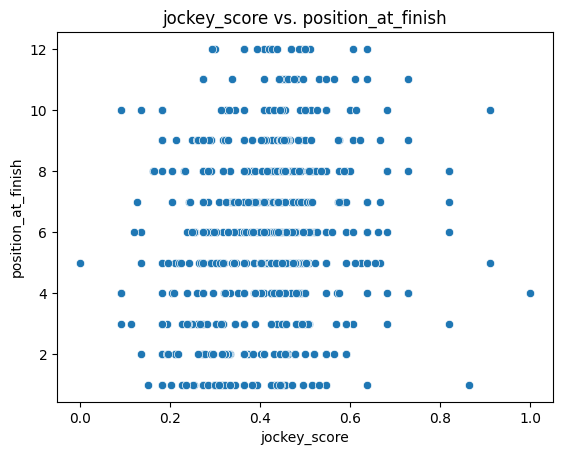

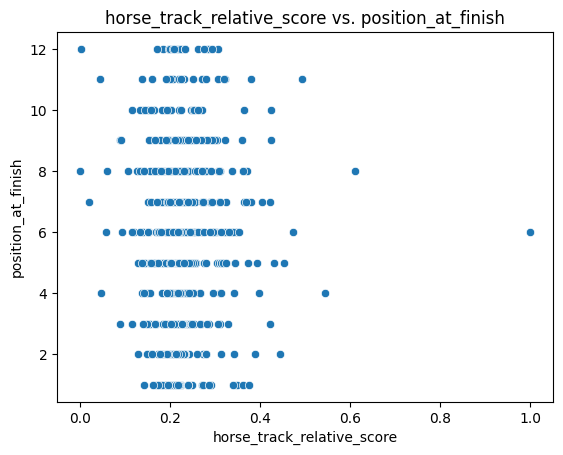

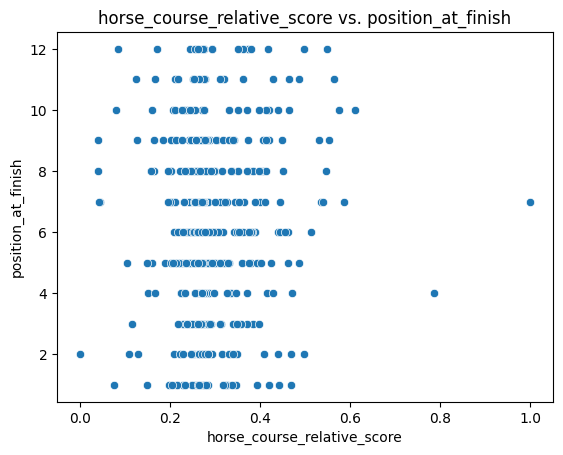

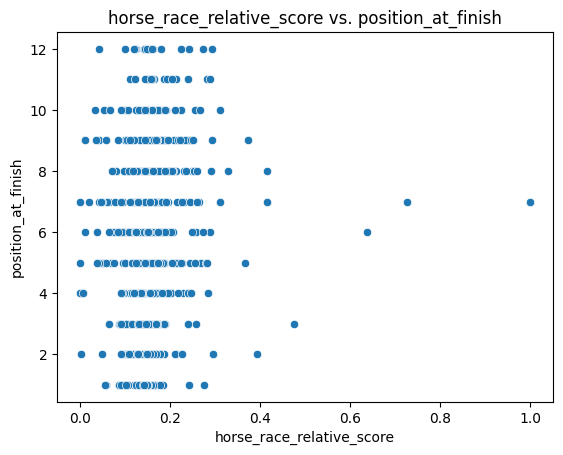

In [15]:
# Feature Linearity Assessment
import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplots for each feature vs. position_at_finish
features = [
    'jockey_score',
    'horse_track_relative_score',
    'horse_course_relative_score',
    'horse_race_relative_score'
]

for feature in features:
    sns.scatterplot(data=df, x=feature, y='position_at_finish')
    plt.title(f"{feature} vs. position_at_finish")
    plt.savefig(f"{feature}_vs_position_at_finish")
    plt.show()

In [21]:
# Preparing for data split
# Features list
features = [
    'jockey_score', 'horse_track_relative_score', 'horse_course_relative_score', 
    'horse_race_relative_score', 'distance_id', 'weight_carried', 'odds',
]
target = 'position_at_finish'

from sklearn.model_selection import train_test_split

# Data split
X = pd.get_dummies(df[features])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Describe the train data
X_train.describe()

,jockey_score,horse_track_relative_score,horse_course_relative_score,horse_race_relative_score,distance_id,weight_carried,odds
count,524.000000,523.000000,524.000000,524.000000,524.000000,524.000000,524.000000
mean,0.411317,0.227557,0.284365,0.157645,0.146223,0.225064,0.237258
std,0.130249,0.071037,0.073298,0.074574,0.133011,0.114647,0.207005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.318182,0.194687,0.261588,0.126263,0.034483,0.177778,0.061126
50%,0.424242,0.220083,0.274938,0.151515,0.172414,0.222222,0.173429
75%,0.479454,0.245000,0.284945,0.172727,0.206897,0.266667,0.387762
max,0.909091,1.000000,0.786747,1.000000,1.000000,1.000000,0.912304


In [23]:
# Export processed data with the target to compare

# Export processed data without the target for predictions
X.to_csv("nyra_2019_complete_processed_no_target.csv", index=False)
print("Processed features only data saved to 'nyra_2019_complete_processed_no_target.csv'")

processed_data_with_target = pd.concat([X, y], axis=1)
processed_data_with_target.to_csv("nyra_2019_complete_processed_with_target.csv", index=False)
print("Processed data with target saved to 'nyra_2019_complete_processed_with_target.csv'")

Processed features only data saved to 'nyra_2019_complete_processed_no_target.csv'
Processed data with target saved to 'nyra_2019_complete_processed_with_target.csv'


In [25]:
# Training the model with Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

randomforest_model_file = "horsemodel_randomforest.pkl"

# Initialize Random Forest
randomforest_model = RandomForestRegressor(
    n_estimators=200,  
    max_depth=None,    
    n_jobs=-1,         
    random_state=42,
    verbose=1,         
    oob_score=True     # Calculate Out-of-Bag score
)

# Train the model
randomforest_model.fit(X_train, y_train)

# Evaluate the model
y_pred = randomforest_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"OOB Score: {randomforest_model.oob_score_}")

# Save the model
joblib.dump(randomforest_model, randomforest_model_file)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s


Mean Squared Error (MSE): 5.928226704545455
R² Score: 0.35891572215015843
Mean Absolute Error (MAE): 1.9068560606060605
OOB Score: 0.34365734847048357


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


['horsemodel_randomforest.pkl']

In [27]:
# Model Evaluation: Comparation to Baseline
baseline_pred = y_test.mean()
baseline_mse = mean_squared_error(y_test, [baseline_pred] * len(y_test))
print("Baseline MSE:", baseline_mse)

Baseline MSE: 9.247187786960513


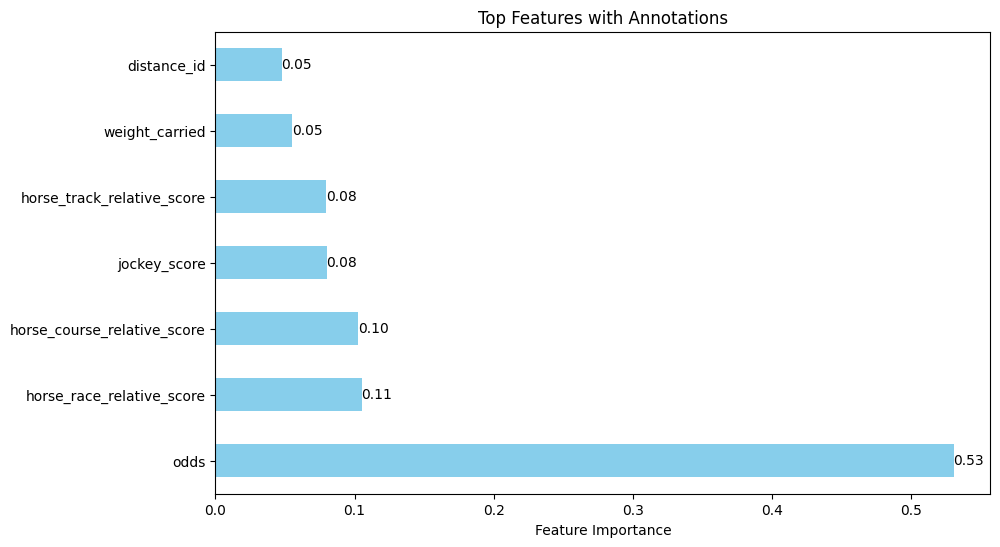

In [29]:
# Model Evaluation - Feature Importance
import matplotlib.pyplot as plt
import pandas as pd

# Sort features by importance
feature_importances = pd.Series(randomforest_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

# Plot the top features
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', color='skyblue')

# Annotate each bar with its value
for index, value in enumerate(top_features.sort_values()):
    plt.text(value, index, f"{value:.2f}", va='center')

plt.xlabel("Feature Importance")
plt.title("Top Features with Annotations")
plt.gca().invert_yaxis()
plt.show()

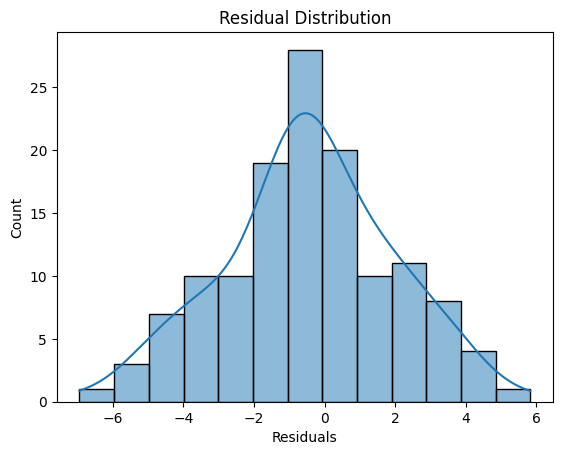

In [31]:
# Model Evaluation: Residual analysis
import seaborn as sns

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()

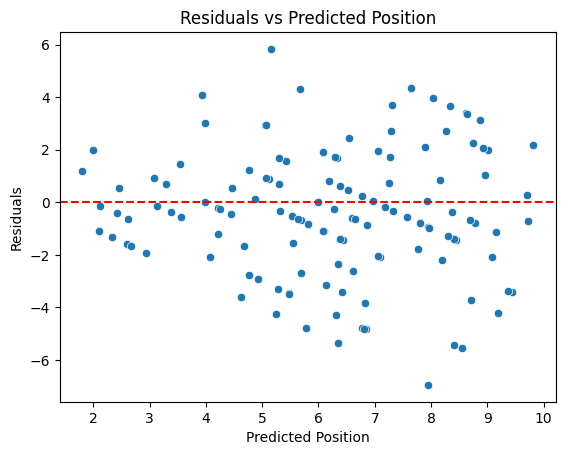

In [33]:
# Model Evaluation: Residuals vs. Predictions
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Position")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Position")
plt.show()

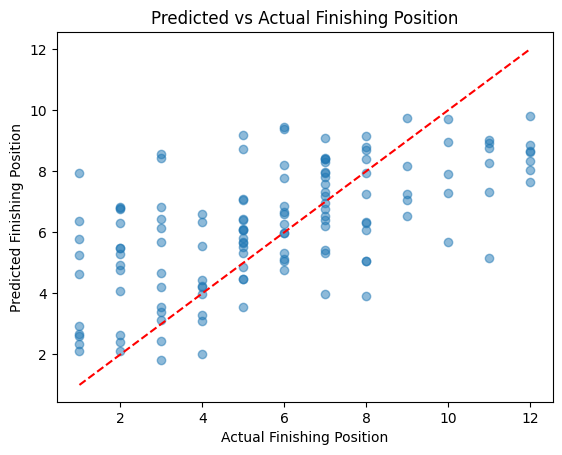

In [35]:
# Model Evaluation: Predicted vs. Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Finishing Position")
plt.ylabel("Predicted Finishing Position")
plt.title("Predicted vs Actual Finishing Position")
plt.show()